In [2]:
import time
inicio = time.time()

# Carga de Paquetes y Librerias

In [3]:
!pip install mapie

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 1.2 MB/s eta 0:00:00


In [4]:
# Basic packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from pandas.plotting import scatter_matrix
from tabulate import tabulate
from numpy import array
import datetime as dt           # Permite trabajar con fechas

# Machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline


# Reducción de dimensiones
from sklearn.decomposition import PCA

# Regresión lineal
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import bartlett

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Pretty print
from pprint import pprint

#SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Google
from google.colab import files  # Permite descargar archivos directamente desde Colab

# Mapie
from mapie.time_series_regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from mapie.metrics import regression_coverage_score, regression_mean_width_score



In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [6]:
# split a univariate sequence into samples
def TrainingSet(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# Carga de Base de Datos

In [7]:
#cargar datos desde drive acceso libre
FILEID = "143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Departamentos.zip && rm -rf /tmp/cookies.txt
!unzip Departamentos.zip
!dir

--2023-07-23 16:13:38--  https://docs.google.com/uc?export=download&confirm=t&id=143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM
Resolving docs.google.com (docs.google.com)... 74.125.135.100, 74.125.135.101, 74.125.135.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.135.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aqbqav63fhbg4tbir0vqia2vpjnkrjn6/1690128750000/15940467605774616319/*/143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM?e=download&uuid=751bc5fa-bb01-46d7-9cb9-d564367fec22 [following]
--2023-07-23 16:13:38--  https://doc-0o-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/aqbqav63fhbg4tbir0vqia2vpjnkrjn6/1690128750000/15940467605774616319/*/143FS8CtU4Wq1C6u43HMYyJC6QqktlZXM?e=download&uuid=751bc5fa-bb01-46d7-9cb9-d564367fec22
Resolving doc-0o-6k-docs.googleusercontent.com (doc-0o-6k-docs.googleusercontent.com)... 108.177.98.132, 

In [8]:
ls

 Colombia_Demanda_Horaria.xlsx   Departamentos.zip
 Colombia.xlsx                   sample_data/
 D_Departamental_Horaria.xlsx    Todos_Departamentos_Depurado.xlsx
'Demanda_Caribe Ajustado.xlsx'


In [9]:
df1=pd.read_excel('/content/Colombia_Demanda_Horaria.xlsx')

In [10]:
df1 = df1.drop('Date', axis=1)
# Se establese nuevamente en el indice temporal en la nueva variable 'a', y al DataFrame se incliye la informacion de frecuencia horaria 'H' de la base de datos
date_rng = pd.date_range(start='2000-01-01', end='2023-01-01', freq='H')
# Establece el índice del DataFrame a las fechas generadas
df1.set_index(date_rng[0:-1], inplace=True)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201624 entries, 2000-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Demand  201624 non-null  float64
dtypes: float64(1)
memory usage: 3.1 MB


<Axes: title={'center': 'Demanda Energia Horaria en Colombia kWh/dia'}, xlabel='Fecha', ylabel='kWh'>

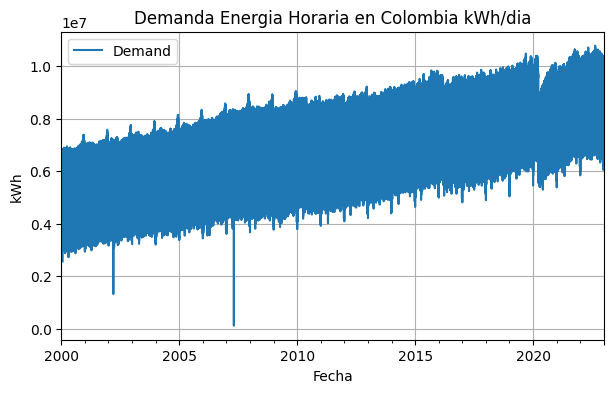

In [12]:
df1.plot(kind='line',figsize=(7,4),title='Demanda Energia Horaria en Colombia kWh/dia', grid=True, ylabel='kWh', xlabel='Fecha',xlim=('2000-01-01','2022-12-31'))


<Axes: title={'center': 'Demanda Energia Horaria en Colombia kWh/dia'}, xlabel='Fecha', ylabel='kWh'>

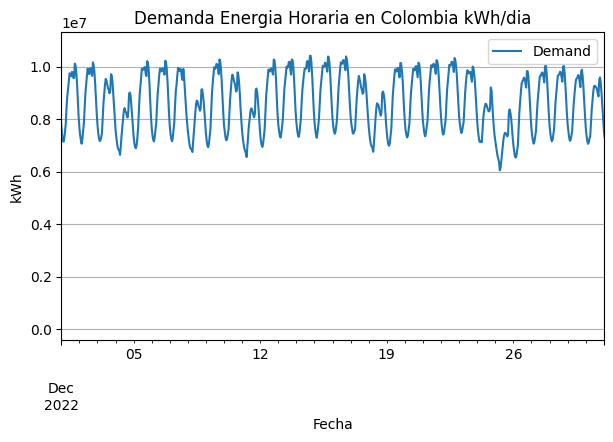

In [13]:
df1.plot(kind='line',figsize=(7,4),title='Demanda Energia Horaria en Colombia kWh/dia', grid=True, ylabel='kWh', xlabel='Fecha',xlim=('2022-12-01','2022-12-31'))

# Normalizacion


In [14]:
Ts1=df1['2020-10-01':'2022-12-31'].values # Un año
print('Tamaño Serie Horaria: ', len(Ts1))

Tamaño Serie Horaria:  19728


In [15]:
# #  Normalizar
# Ts1 = (Ts1-min(Ts1))/(max(Ts1)-min(Ts1))
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(Ts1)
Ts1=scaler.transform(Ts1)

# Modelos DL


## Time Step=30

### Conjunto de Entrenamiento

In [28]:
#  Particion X,Y y Time_step/step_back/window
step_back = 30

X1, Y1 = TrainingSet(Ts1,step_back)

#  Particion Train_Test

Part = 0.8

# Serie 1
X_train = X1[:15781].reshape(15781,step_back)
X_Val = X1[15781:16570].reshape(789,step_back)
X_test = X1[16570:].reshape(3128,step_back)

# X_test1=X_test1.reshape(len(X_test1),step_back)
# X_train1=X_train1.reshape(len(X_train1),step_back)

Y_train = Y1[:15781].reshape(15781)
Y_Val = Y1[15781:16570].reshape(789)
Y_test = Y1[16570:].reshape(3128)
# Y_test1=Y_test1.reshape(len(Y_test1),step_back)
# Y_train1=Y_train1.reshape(len(Y_train1),step_back)



In [29]:
print('Tamaño X_train: ', X_train.shape, 'Tamaño Y_train: ', Y_train.shape )
print('Tamaño X_val: ', X_Val.shape, 'Tamaño Y_val: ', Y_Val.shape, )
print('Tamaño X_test: ', X_test.shape, 'Tamaño Y_test: ', Y_test.shape, )
print('-----------------------------------------------------------------------')


Tamaño X_train:  (15781, 30) Tamaño Y_train:  (15781,)
Tamaño X_val:  (789, 30) Tamaño Y_val:  (789,)
Tamaño X_test:  (3128, 30) Tamaño Y_test1:  (3128,)
-----------------------------------------------------------------------


In [30]:
# Nuemero de Epocas
N=100
bsz=512

In [31]:
callbacks = [keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=0.0001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, verbose=1),]

### ANN

In [ ]:
model_ANN = keras.models.Sequential([
                                     keras.layers.Dense(100,input_shape=(step_back,)),
                                     keras.layers.Dense(100),
                                     keras.layers.Dense(100),
                                     keras.layers.Dense(1)
])
model_ANN.summary()

# Training

model_ANN.compile(loss="mse", optimizer="adam", metrics=['mae', 'mse'])
model_ANN.fit(X_train, Y_train, epochs=N, batch_size=bsz, callbacks=callbacks, validation_data=[ X_Val, Y_Val ])

In [34]:
model_ANN.save('model_MPL_U_30.h5')
print('Model Saved!')

Model Saved!


In [35]:
files.download('/content/model_MPL_U_30.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
X_train=X_train.copy()
y_train=Y_train.copy()
X_cal=X_Val.copy()
y_cal=Y_Val.copy()
X_val=X_test.copy()
y_val=Y_test.copy()

In [165]:
alpha = 0.91
f=model_ANN.predict(X_cal)
model=model_ANN
N=len(y_cal)
q_yhat=np.quantile(np.abs(y_cal-f),np.ceil((N+1)*(1-alpha))/N)
print(q_yhat)

25/25 [==============================] - 0s 1ms/step
0.02879036031090307


In [166]:
f_val=model.predict(X_val).flatten()

98/98 [==============================] - 0s 1ms/step


In [167]:
def calculate_coverage(lower_bound,upper_bound,y_true):
    out_of_bound=0
    N=len(y_true)

    for i in range(N):
        if y_true[i]<lower_bound[i] or y_true[i]>upper_bound[i]:
            out_of_bound+=1

    return 1-out_of_bound/N

print('Coverage of {}'.format(calculate_coverage(f_val-q_yhat,f_val+q_yhat,y_val)))
Cover=calculate_coverage(f_val-q_yhat,f_val+q_yhat,y_val)

Coverage of 0.9111253196930946


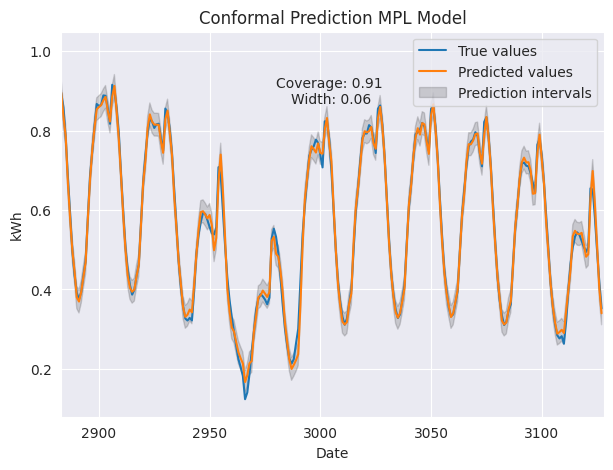

In [174]:

plt.rcParams["figure.figsize"] = (7,5)
sns.set_style("darkgrid", {'axes.grid' : True})
ind=[i for i in range(len(y_val))]
plt.plot(ind,y_val,label='True values')
plt.plot(ind,f_val,label='Predicted values')
plt.fill_between(ind,f_val-q_yhat,f_val+q_yhat,
                 color='k', alpha=.15,label='Prediction intervals')

plt.xlim(2883,3128)

center_x = (2883 + 3128) / 2
center_y = (max(f_val) + min(f_val)) / 2
plt.text(3005, 0.9, f"Coverage: {round(Cover,2)} \nWidth: {round(2*q_yhat, 2)}",  ha="center", va="center")

plt.title("Conformal Prediction MPL Model")

plt.xlabel("Date")
plt.ylabel("kWh")

plt.legend()
plt.show()

In [127]:
print(2*q_yhat)

0.06335992544784784


## TimeStep =36

### Conjunto de Entrenamiento


In [182]:

N=100
bsz=512

#  Particion X,Y y Time_step/step_back/window
step_back = 36

X1, Y1 = TrainingSet(Ts1,step_back)

#  Particion Train_Test

Part = 0.8

# Serie 1
X_train = X1[:15781].reshape(15781,step_back)
X_Val = X1[15781:16570].reshape(789,step_back)
X_test = X1[16570:].reshape(3122,step_back)


Y_train = Y1[:15781].reshape(15781)
Y_Val = Y1[15781:16570].reshape(789)
Y_test = Y1[16570:].reshape(3122)



In [183]:
print('Tamaño X_train: ', X_train.shape, 'Tamaño Y_train: ', Y_train.shape )
print('Tamaño X_val: ', X_Val.shape, 'Tamaño Y_val: ', Y_Val.shape, )
print('Tamaño X_test: ', X_test.shape, 'Tamaño Y_test: ', Y_test.shape, )
print('-----------------------------------------------------------------------')


Tamaño X_train:  (15781, 36) Tamaño Y_train:  (15781,)
Tamaño X_val:  (789, 36) Tamaño Y_val:  (789,)
Tamaño X_test:  (3122, 36) Tamaño Y_test:  (3122,)
-----------------------------------------------------------------------


### RNN

In [ ]:
model_RNN = keras.models.Sequential([
                                     keras.layers.SimpleRNN(100, return_sequences=True, input_shape=(step_back,1)),
                                     keras.layers.SimpleRNN(100, return_sequences=True),
                                     keras.layers.SimpleRNN(100, return_sequences=True),
                                     keras.layers.SimpleRNN(1)
])
model_RNN.summary()

# Training

metrics=['mae', 'mse']
model_RNN.compile(loss="mse", optimizer="adam", metrics=metrics)
history = model_RNN.fit(X_train, Y_train, epochs=N, batch_size=bsz, callbacks=callbacks, validation_data=[ X_Val, Y_Val ])

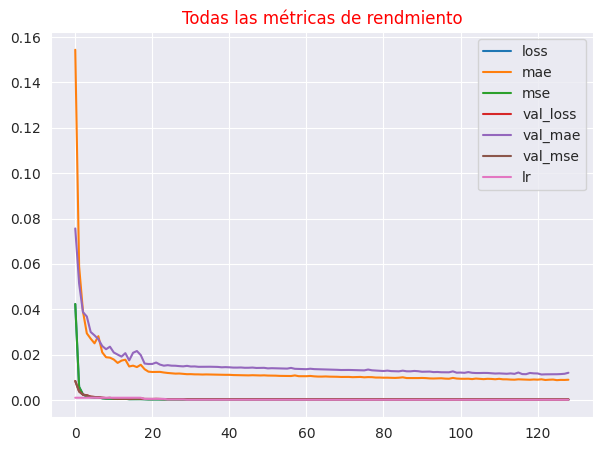

In [185]:
hpd = pd.DataFrame(history.history)
hpd.plot()
plt.title('Todas las métricas de rendmiento', c='r')
plt.grid(True)
plt.show()

In [187]:
model_RNN.save('model_RNN_U_36.h5')
print('Model Saved!')

Model Saved!


In [188]:
files.download('/content/model_RNN_U_36.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [189]:
X_train=X_train.copy()
y_train=Y_train.copy()
X_cal=X_Val.copy()
y_cal=Y_Val.copy()
X_val=X_test.copy()
y_val=Y_test.copy()

## Conformal RNN U 36

In [191]:
alpha = 0.91
f=model_RNN.predict(X_cal)
model=model_RNN
N=len(y_cal)
q_yhat=np.quantile(np.abs(y_cal-f),np.ceil((N+1)*(1-alpha))/N)
print(q_yhat)
f_val=model.predict(X_val).flatten()

25/25 [==============================] - 0s 14ms/step
0.02814368343266774
98/98 [==============================] - 1s 14ms/step


In [192]:
def calculate_coverage(lower_bound,upper_bound,y_true):
    out_of_bound=0
    N=len(y_true)

    for i in range(N):
        if y_true[i]<lower_bound[i] or y_true[i]>upper_bound[i]:
            out_of_bound+=1

    return 1-out_of_bound/N

print('Coverage of {}'.format(calculate_coverage(f_val-q_yhat,f_val+q_yhat,y_val)))
Cover=calculate_coverage(f_val-q_yhat,f_val+q_yhat,y_val)

Coverage of 0.9381806534272902


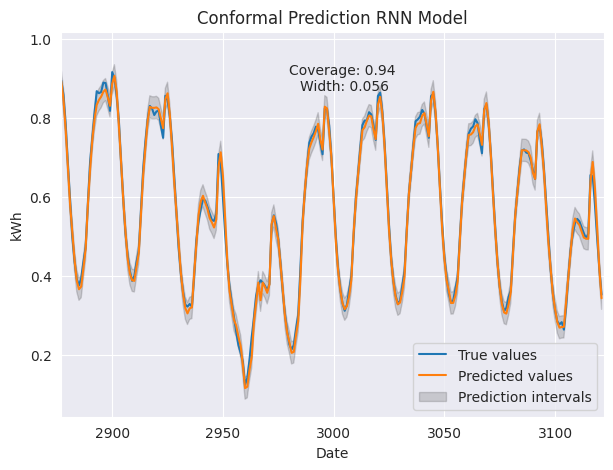

In [195]:

plt.rcParams["figure.figsize"] = (7,5)
sns.set_style("darkgrid", {'axes.grid' : True})
ind=[i for i in range(len(y_val))]
plt.plot(ind,y_val,label='True values')
plt.plot(ind,f_val,label='Predicted values')
plt.fill_between(ind,f_val-q_yhat,f_val+q_yhat,
                 color='k', alpha=.15,label='Prediction intervals')

plt.xlim(2877,3122)

center_x = (2883 + 3128) / 2
center_y = (max(f_val) + min(f_val)) / 2
plt.text(3005, 0.9, f"Coverage: {round(Cover,2)} \nWidth: {round(2*q_yhat, 3)}",  ha="center", va="center")

plt.title("Conformal Prediction RNN Model")

plt.xlabel("Date")
plt.ylabel("kWh")

plt.legend()
plt.show()

In [194]:
print(2*q_yhat)

0.05628736686533548


# Tiempo

In [ ]:
fin = time.time()

# Calcula el tiempo transcurrido
tiempo_transcurrido = fin - inicio
print("Tiempo transcurrido: ", tiempo_transcurrido, "segundos")